In [12]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

In [13]:
PROJECT_ROOT = Path().resolve()

while not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

# Build correct file path
file_path = PROJECT_ROOT / "data" / "processed" / "nifty50_processed.csv"


In [14]:
df = pd.read_csv(file_path, low_memory=False)
df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Stock
0,0,2010-01-04,55.718451,57.859506,55.183188,57.553642,1860224,ADANIENT.NS
1,1,2010-01-05,57.732052,59.127560,57.732052,58.885418,2280286,ADANIENT.NS
2,2,2010-01-06,59.006477,65.888437,58.624147,64.696838,7326390,ADANIENT.NS
3,3,2010-01-07,66.194331,66.194331,61.555372,62.026913,4759208,ADANIENT.NS
4,4,2010-01-08,62.421990,64.741473,61.453420,62.810696,3324076,ADANIENT.NS
...,...,...,...,...,...,...,...,...
177231,177231,2024-12-24,288.250678,289.844270,283.844884,286.188385,8837902,WIPRO.NS
177232,177232,2024-12-26,286.282136,287.735125,284.969781,285.954041,6516148,WIPRO.NS
177233,177233,2024-12-27,286.094662,291.437828,285.625962,289.750519,8063921,WIPRO.NS
177234,177234,2024-12-30,289.750526,290.031734,283.704280,284.688568,13709891,WIPRO.NS


In [15]:
stock = "RELIANCE.NS"

stock_df = df[df["Stock"] == stock].copy()

stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date")

series = stock_df.set_index("Date")["Close"].astype(float)

# remove duplicate timestamps
series = series.groupby(series.index).mean()

# remove timezone if exists
if series.index.tz is not None:
    series.index = series.index.tz_localize(None)

# create business index
full_index = pd.date_range(series.index.min(), series.index.max(), freq="B")

series = series.reindex(full_index).ffill()

# remove leading NaN if any
series = series.loc[series.first_valid_index():]

print(series.head())
print("NaN count:", series.isna().sum())


2010-01-04    218.593063
2010-01-05    217.617493
2010-01-06    221.133682
2010-01-07    224.802307
2010-01-08    224.212875
Freq: B, Name: Close, dtype: float64
NaN count: 0


In [16]:
print(len(stock_df))
print(series.head(10))
print(series.index[:5])
print(series.index.dtype)

3700
2010-01-04    218.593063
2010-01-05    217.617493
2010-01-06    221.133682
2010-01-07    224.802307
2010-01-08    224.212875
2010-01-11    219.812607
2010-01-12    220.391815
2010-01-13    221.255661
2010-01-14    227.983185
2010-01-15    225.757584
Freq: B, Name: Close, dtype: float64
DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08'],
              dtype='datetime64[ns]', freq='B')
datetime64[ns]


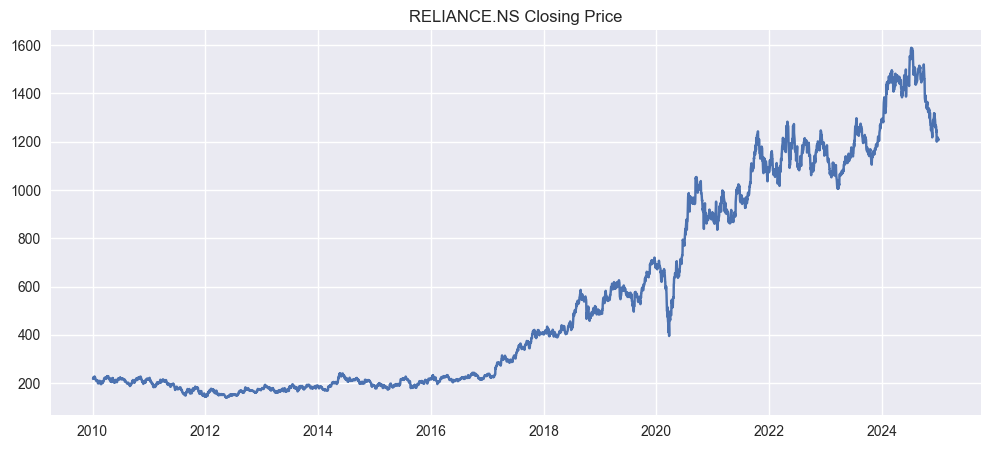

In [17]:
plt.figure(figsize=(12,5))
plt.plot(series)
plt.title(f"{stock} Closing Price")
plt.show()

In [18]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

    if result[1] < 0.05:
        print("Series is stationary ✅")
    else:
        print("Series is NOT stationary ❌")

adf_test(series)

ADF Statistic: -0.21395525426598494
p-value: 0.9368376161579479
Series is NOT stationary ❌


In [19]:
train_size = int(len(series) * 0.8)

train = series[:train_size]
test = series[train_size:]

In [20]:

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3129
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11080.051
Date:                Fri, 20 Feb 2026   AIC                          22172.102
Time:                        08:35:20   BIC                          22208.391
Sample:                    01-04-2010   HQIC                         22185.127
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0098      0.009      1.077      0.281      -0.008       0.028
ar.L2          0.0071      0.009      0.784      0.433      -0.011       0.025
ar.L3         -0.0224      0.008     -2.650      0.0

In [21]:
predictions = model_fit.forecast(steps=len(test))

In [22]:
rmse = np.sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)

print("RMSE:", rmse)
print("MAE :", mae)


RMSE: 219.8740572695422
MAE : 169.86662873417822


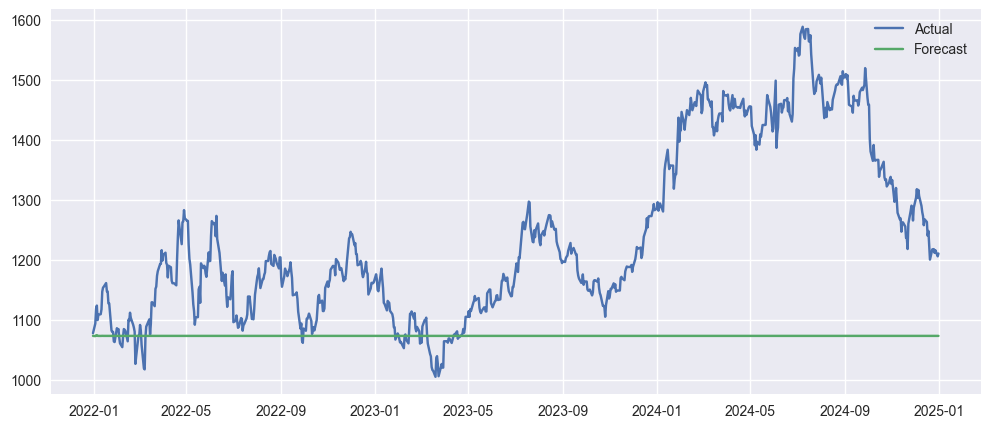

In [23]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, predictions, label="Forecast")
plt.legend()
plt.show()

In [24]:
# last actual price before test period
last_train_price = series.iloc[train_size]

# rebuild price predictions
predicted_price = last_train_price + predictions.cumsum()


In [25]:
actual_price = series.iloc[train_size+1 : train_size+1+len(predictions)]

ValueError: x and y must have same first dimension, but have shapes (782,) and (783,)

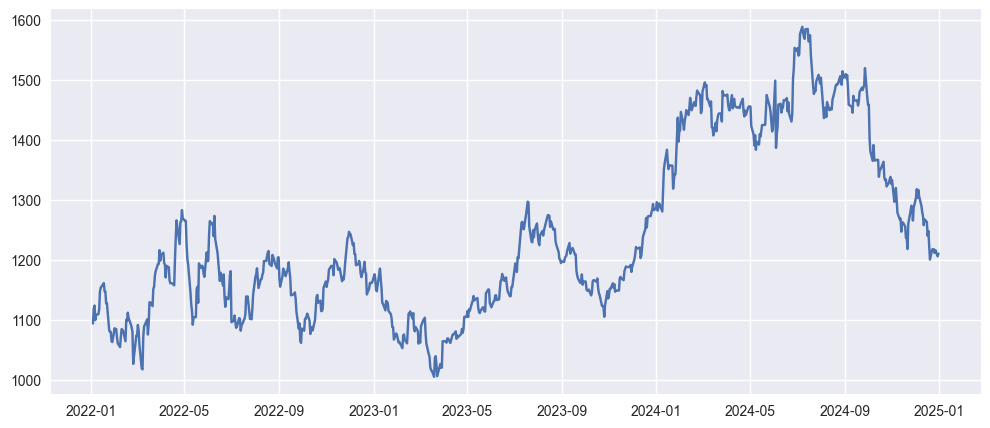

In [26]:
plt.figure(figsize=(12,5))
plt.plot(actual_price.index, actual_price, label="Actual Price")
plt.plot(actual_price.index, predicted_price, label="Forecasted Price")
plt.legend()
plt.title("ARIMA Price Forecast")
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))
mae = mean_absolute_error(actual_price, predicted_price)

print("RMSE (price):", rmse)
print("MAE  (price):", mae)